In [5]:
import arviz as az
import numpy as np
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt 

%config InlineBackend.figure_format = "retina"
RANDOM_SEED = 4000
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

print(f"{pm.__version__=}")

pm.__version__='3.11.5'


In [6]:
N = 1000
W = np.array([0.35, 0.4, 0.25])
MU = np.array([0.0, 2.0, 5.0])
SIGMA = np.array([0.5, 0.5, 1.0])

print(f"{MU.size = }")
component = np.random.choice(MU.size, size=N, p=W)
print(f"{component.size = }")
print(f"{component.shape = }")

x = np.random.normal(MU[component], SIGMA[component], size=N)

MU.size = 3
component.size = 1000
component.shape = (1000,)


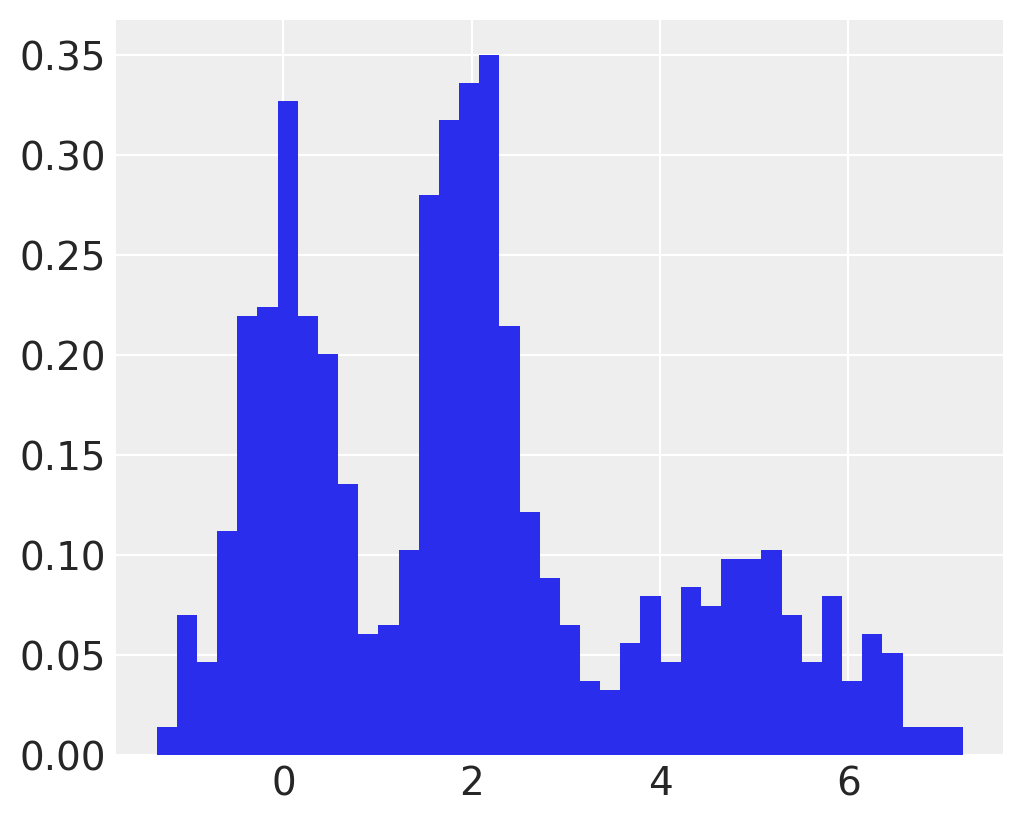

In [9]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(x, bins=40, density=True, lw=0)
plt.show()

GMMの最も自然な方法は、潜在変数モデルを使ったモデリングでたとえば以下のようにする。


$$ \mu_1, ..., \mu_K \sim N(0, \sigma^2) $$
$$ \tau_1, ..., \tau_K \sim \rm{Gamma}\it(a, b) $$
$$ \bm{w} \sim \rm{Dir}(\bm{\alpha}) $$
$$ z|\bm{w} \sim \rm{Cat}(\bm{w}) $$
$$ x|\bm{z} \sim N(\mu_z, \tau^{-1}_z) $$


デメリット：事後分布は離散的潜在変数$z$のサンプリングに依存する  
→ slow mixingを起こす、 分布の端っこを余計に探索する

代わりに、上と同室のパラメータ化をする方法は$z$で周辺化すること。つまり、以下のモデリングを使う。

$$ \mu_1, ..., \mu_K \sim N(0, \sigma^2) $$
$$ \tau_1, ..., \tau_K \sim \rm{Gamma}\it(a, b) $$
$$ \bm{w} \sim \rm{Dir}(\bm{\alpha}) $$
$$ f(x|\bm{w}) = \sum_{i=1}^{K}w_i N(x | \mu_i, \tau_i^{-1}) $$


これで、faster mixing、分布端のbetter explorationができる。Stanコミュニティでは常套のやり方らしい。  
PyMCでは、`NormalMixture`クラスを使って行える。

In [18]:
with pm.Model() as model:
    w = pm.Dirichlet("w", a=np.ones_like(W))

    mu = pm.Normal(
        "mu",
        mu=np.zeros_like(W),
        sigma=1.0,
        shape=W.size,
        transform=pm.transforms.ordered,
        testval=[1, 2, 3],
    )
    tau = pm.Gamma("tau", 1.0, 1.0, shape=W.size)

    x_obs = pm.NormalMixture("x_obs", w=w, mu=mu, tau=tau, observed=x)

with model:
    trace = pm.sample(5000, n_init=10000, tune=1000, return_inferencedata=True)

    ppc_trace = pm.sample_posterior_predictive(trace, var_names=["x_obs"], keep_size=True)

trace.add_groups(posterior_predictive=ppc_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, mu, w]
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module name

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 18 seconds.


↓重み`W`と要素の平均値`MU`の真の値をよく捉えてることがわかる。`w`と`mu`に注目。

array([[<AxesSubplot: title={'center': 'w'}>,
        <AxesSubplot: title={'center': 'w'}>],
       [<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'tau'}>,
        <AxesSubplot: title={'center': 'tau'}>]], dtype=object)

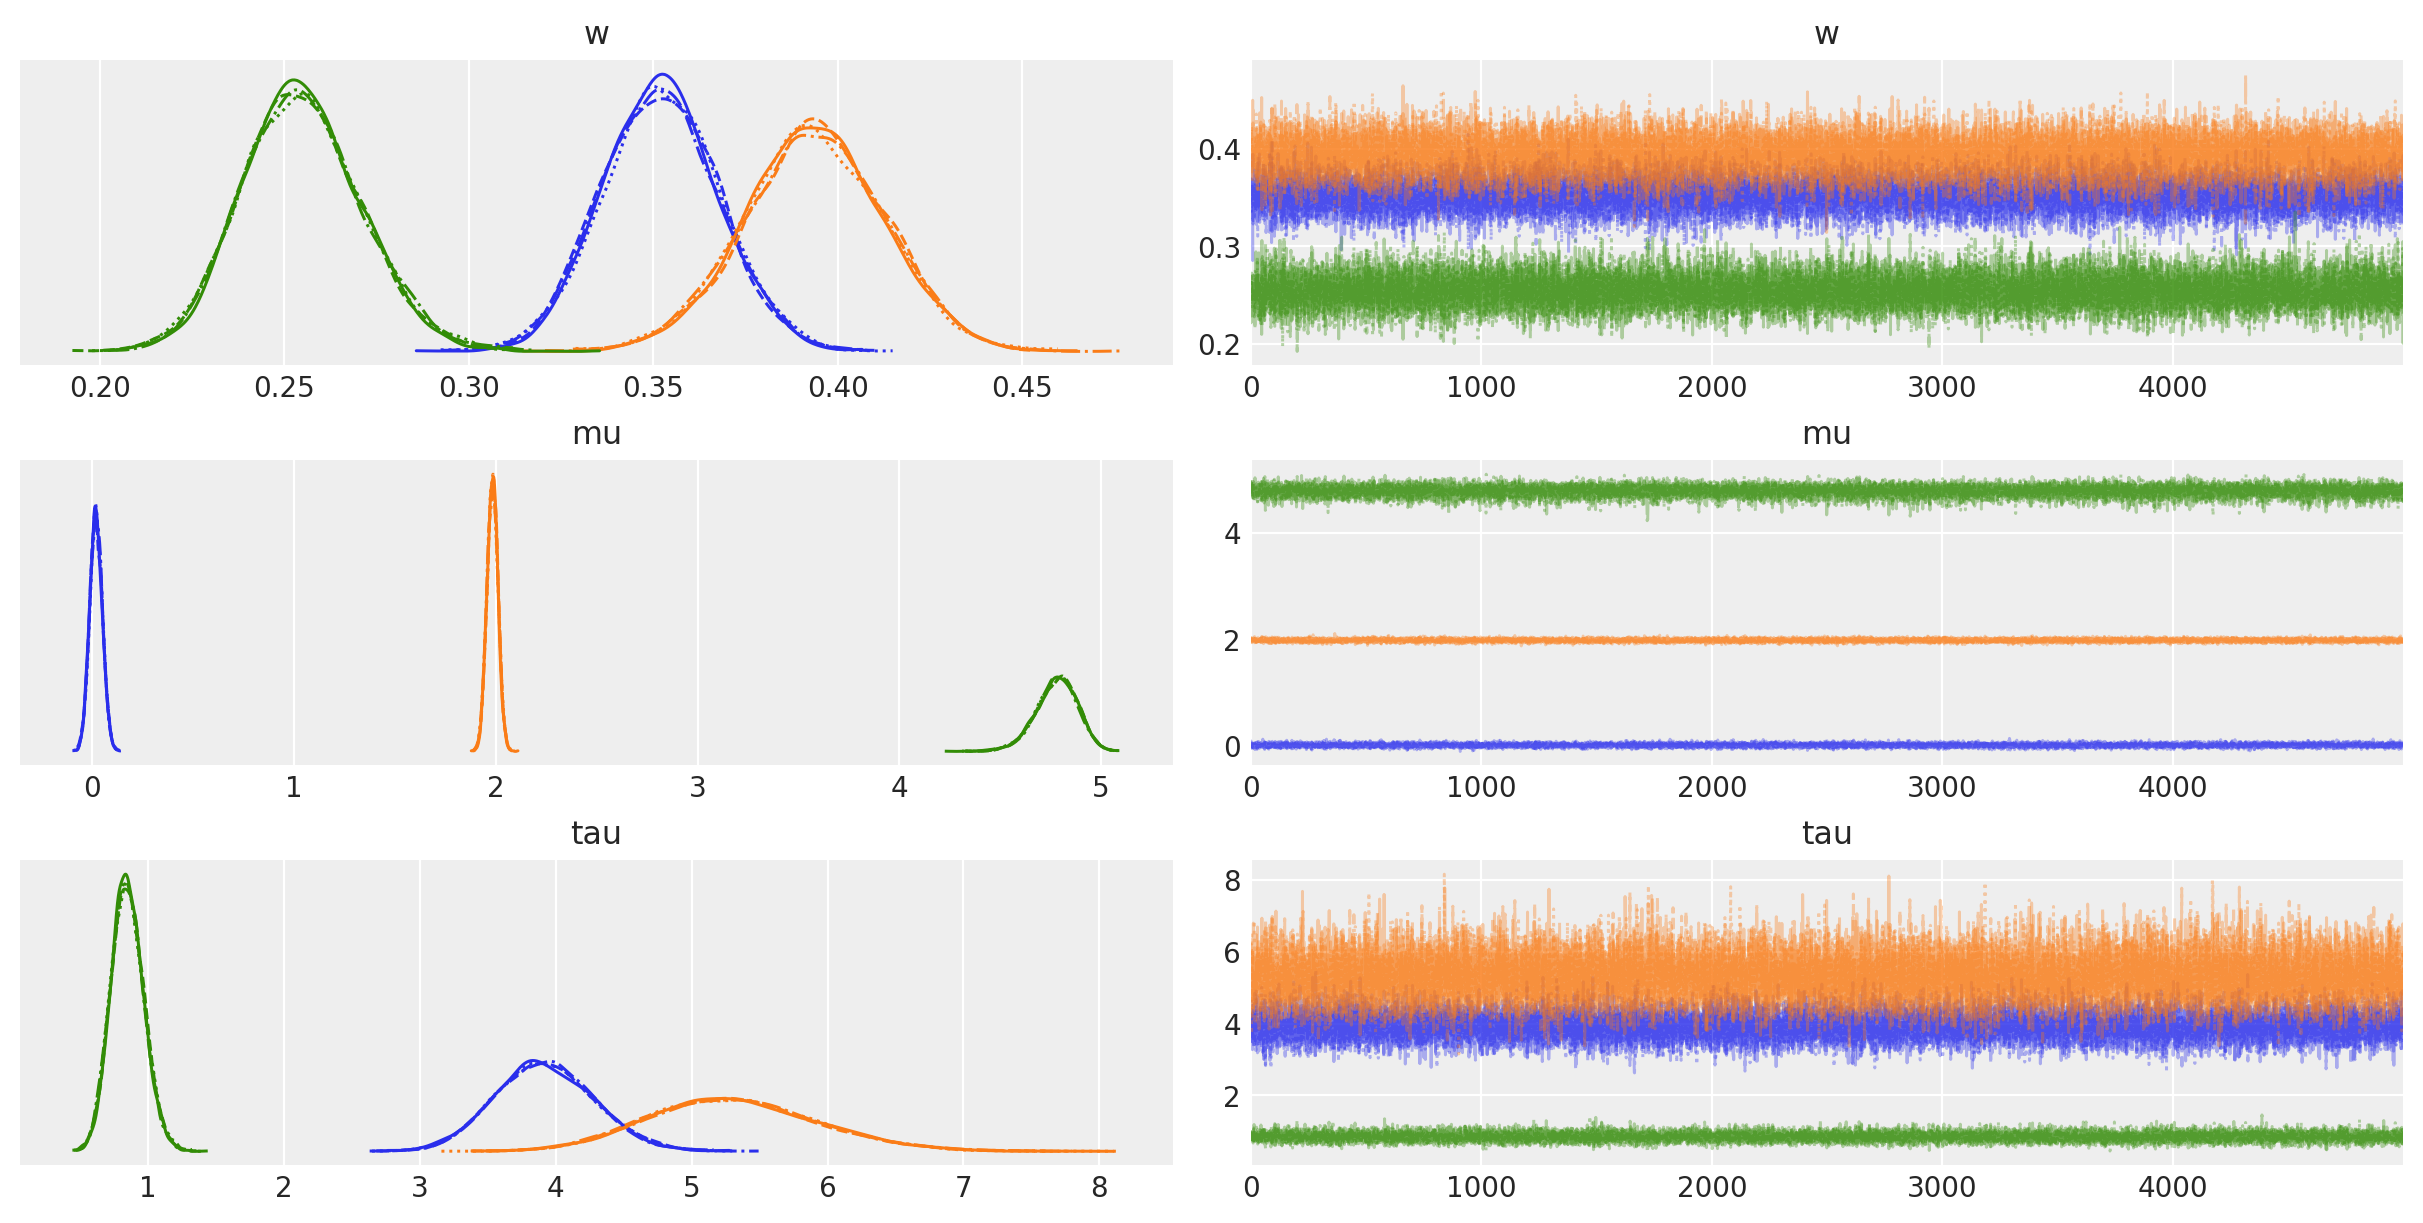

In [19]:
az.plot_trace(trace, var_names=["w", "mu", "tau"])

↑ # transform=pm.transforms.ordered,
        # testval=[1, 2, 3],

どちらも今回は影響なし。。しかし`az.plot_posterior(trace, var_names=["w", "mu"])`の結果に影響ある模様。なぜだろう。。

array([[<AxesSubplot: title={'center': 'w\n0'}>,
        <AxesSubplot: title={'center': 'w\n1'}>,
        <AxesSubplot: title={'center': 'w\n2'}>],
       [<AxesSubplot: title={'center': 'mu\n0'}>,
        <AxesSubplot: title={'center': 'mu\n1'}>,
        <AxesSubplot: title={'center': 'mu\n2'}>]], dtype=object)

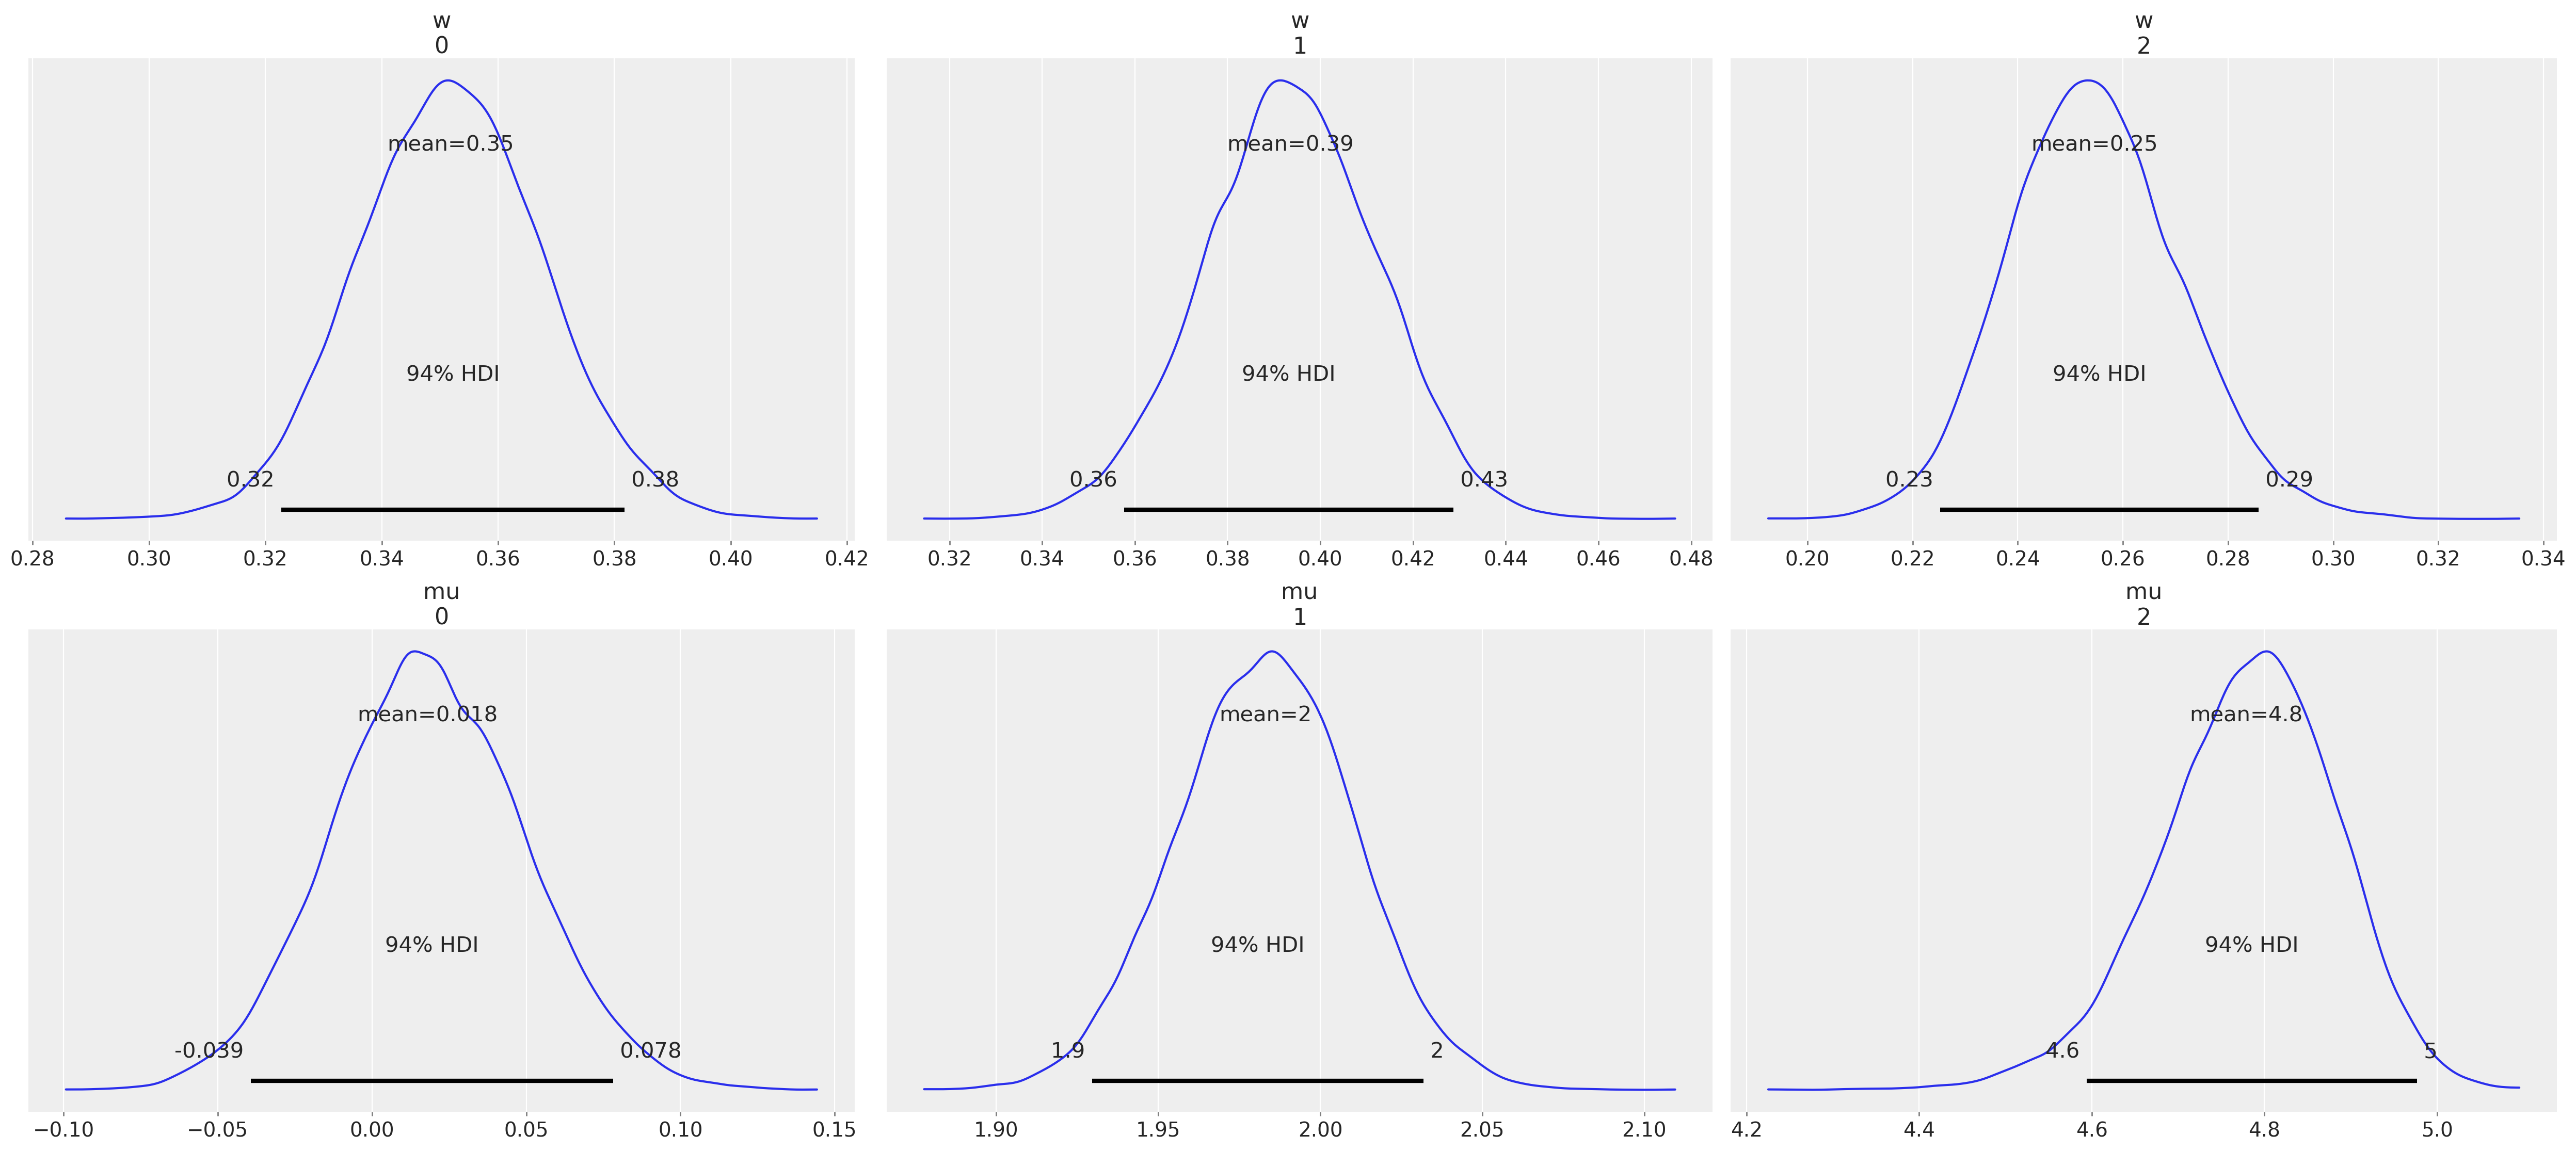

In [20]:
az.plot_posterior(trace, var_names=["w", "mu"])


<AxesSubplot: xlabel='x_obs / x_obs'>

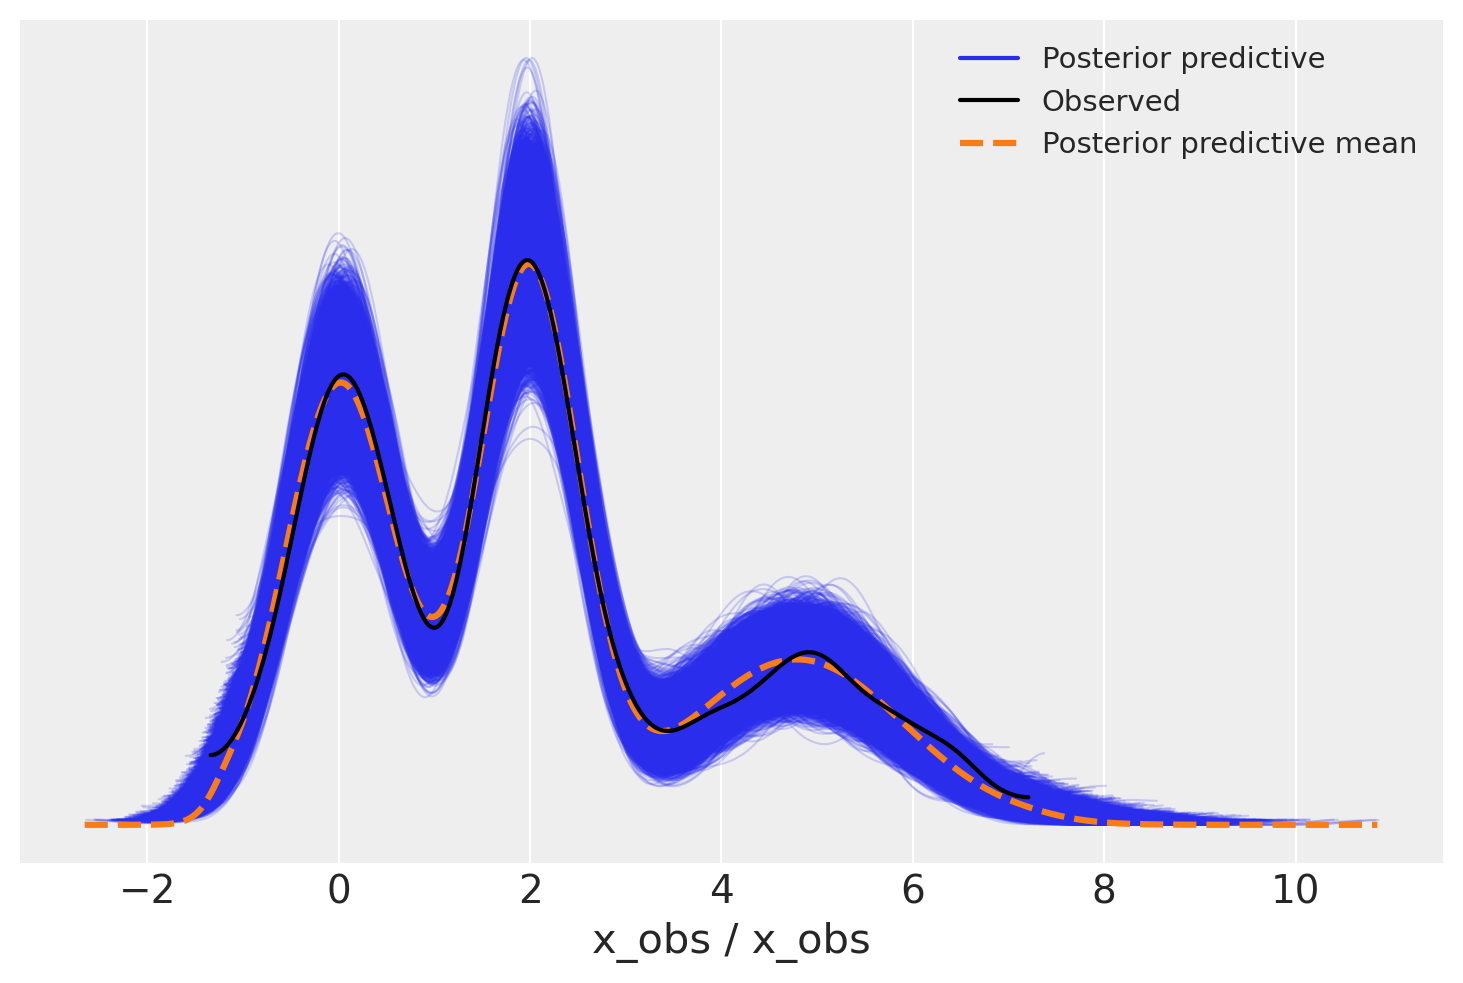

In [21]:
az.plot_ppc(trace)